In [3]:
import numpy as np
import matplotlib.pyplot as plt

from astropy.io import fits

from StokesIFit import StokesIFit as SIF
from StokesIFit import nGauss as nGauss

In [4]:
I_hdu = fits.open('1720_I.FITS')
I_d = np.squeeze(I_hdu[0].data)
I_h = I_hdu[0].header

V_hdu = fits.open('1720_V.FITS')
V_d = np.squeeze(V_hdu[0].data)
V_h = V_hdu[0].header

# Reading the spectrum of the selected pixel
x = 127
y = 127
spec = I_d[:, x, y]
V = V_d[:, x, y]
# plt.plot(spec)
# plt.plot(V)
# plt.imshow(I_d[255, :, :])

In [5]:
# Fit Stokes I into multiple Gaussians
I_Fitter = SIF(spec, 0.5)
I_popt, I_pcov, I_fit = I_Fitter.fit()

In [6]:
# Definition of Stokes V and Stokes V correction term (including only the beta term)

def StokesV(I, alpha, beta):
    """
    Function to fit the Stokes V spectrum as a function of Stokes I and frequency
    """
    return alpha * I + beta * np.gradient(I)

def StokesVCorr(I, beta):
    """
    Stokes V correction term by fitting each Gaussain term individually
    """
    return beta * np.gradient(I)

In [7]:
# Pefroming the fit first gettin the alpha term and then the beta terms of each Gaussian

from scipy.optimize import curve_fit
tofit = V
popt, pcov = curve_fit(StokesV, I_fit, tofit, p0=[0.1, 0.5])
tofit -= popt[0] * I_fit
bestfit = popt[0] * I_fit
print("Alpha: ", popt[0])
B = []
for i in range(0, len(I_Fitter.popt), 3):
    gauss = nGauss(np.arange(0, len(tofit), 1.), *I_Fitter.popt[i:i+3])
    popt, pcov = curve_fit(StokesVCorr, gauss, tofit, p0=[0.5])
    B.append(popt[0])

for i in range(0, len(I_Fitter.popt), 3):
    gauss = nGauss(np.arange(0, len(tofit), 1.), *I_Fitter.popt[i:i+3])
    bestfit += StokesVCorr(gauss, B[i//3])

print("Beta of each Gaussian: ", *B)

Alpha:  0.05515550108152577
Beta of each Gaussian:  1.2961605746143863 0.5117070553803226 0.5298204388063904 0.6483369275712716


Standard Deviation: 0.040913233875449366


<Figure size 1600x700 with 0 Axes>

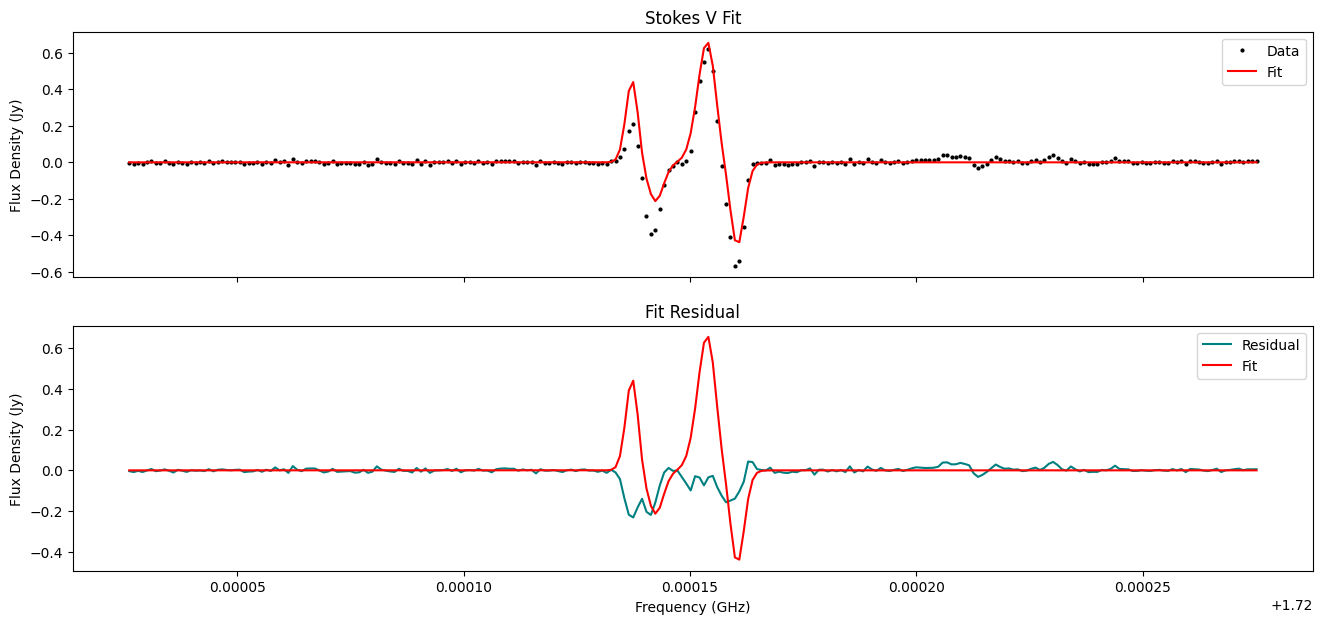

Standard Deviation 0.02435986206101717


<Figure size 1600x700 with 0 Axes>

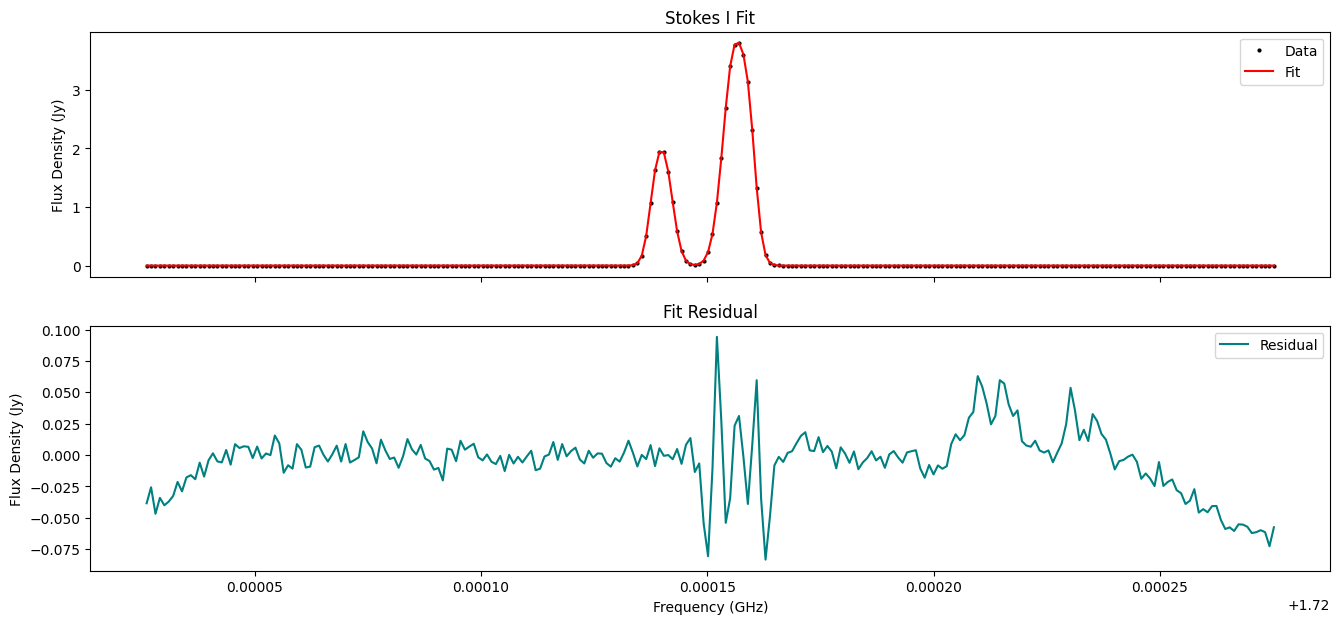

In [8]:
# Plotting
# fit = StokesV(I_fit, *popt)
fit = bestfit
print("Standard Deviation:", np.std(V-fit))
x = np.linspace(start = I_h['CRVAL3'], stop = I_h['CRVAL3'] + (I_h['NAXIS3'] - I_h['CRPIX3']) * I_h['CDELT3'], num = I_h['NAXIS3']) / 1e9
plt.figure(figsize = (16, 7))
fig, (ax1, ax2) = plt.subplots(2, 1, figsize= (16, 7), sharex = True, sharey = False )
ax1.plot(x, V, 'o', color = 'k', markersize = 2, label = "Data")
ax1.plot(x, fit, color = 'red', label = "Fit")
ax1.set(title="Stokes V Fit", ylabel = "Flux Density (Jy)")
ax2.plot(x, (V - fit), label = "Residual", color = 'teal')
ax2.plot(x, fit, color = 'red', label = "Fit")
# ax2.plot(x, V, 'o', color = 'k', markersize = 2, label = "Data")
ax2.set(title="Fit Residual", xlabel="Frequency (GHz)", ylabel = "Flux Density (Jy)")
ax1.legend()
ax2.legend()
plt.show()

fit = I_fit
y = spec
print("Standard Deviation", np.std(y-fit))
plt.figure(figsize = (16, 7))
fig, (ax1, ax2) = plt.subplots(2, 1, figsize= (16, 7), sharex = True, sharey = False )
ax1.plot(x, fit, 'o', color = 'k', markersize = 2, label = "Data")
ax1.plot(x, fit, color = 'red', label = "Fit")
ax1.set(title="Stokes I Fit", ylabel = "Flux Density (Jy)")
ax2.plot(x, (y-fit), label = "Residual", color = 'teal')
# ax2.plot(x, fit, label = "Fit", color = 'red')
ax2.set(title="Fit Residual", xlabel="Frequency (GHz)", ylabel = "Flux Density (Jy)")
ax1.legend()
ax2.legend()
plt.show()